## Deep-Learning model: CNN 3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.fft import fft

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
# Helper Functions

def pad_or_truncate(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    return signal

def apply_fft(signal):
    fft_values = np.abs(np.fft.fft(signal))[:len(signal)//2]  # Take only positive frequencies
    return fft_values

def compute_derivative(signal):
    return np.diff(signal, prepend=signal[0])  # keep same length

def standardize_signal_column(signals):
    scaler = StandardScaler()
    return scaler.fit_transform(signals)

# Load and Prepare Data

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/Healthcare/full_ecg_with_answers.csv')

# Drop metadata columns
metadata_cols = ['File_ID', 'Num_Leads', 'Sampling_Rate', 'Num_Samples', 'Gain', 'Offset', 'Signal_Type']
df = df.drop(columns=metadata_cols)

# Convert string to array
df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: np.array(eval(x)))

# Pad/truncate to 18000
df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: pad_or_truncate(x, 18000))

# Add FFT
df['ECG_FFT'] = df['ECG_Signal'].apply(apply_fft)
df['ECG_FFT'] = df['ECG_FFT'].apply(lambda x: pad_or_truncate(x, 18000))

# Add Derivative
df['ECG_Deriv'] = df['ECG_Signal'].apply(compute_derivative)
df['ECG_Deriv'] = df['ECG_Deriv'].apply(lambda x: pad_or_truncate(x, 18000))

# Convert label to numeric
label_mapping = {'N': 0, 'A': 1, 'O': 2, '~': 3}
df['Label_numeric'] = df['Label'].map(label_mapping)

# Convert to Arrays for SMOTE

# Stack all 3 channels
X_all = np.stack([
    np.stack(df['ECG_Signal'].values),
    np.stack(df['ECG_FFT'].values),
    np.stack(df['ECG_Deriv'].values)
], axis=1)

# Flatten for SMOTE
X_flat = X_all.reshape(X_all.shape[0], -1)
y = df['Label_numeric'].values

# SMOTE
smote = SMOTE(sampling_strategy={1: 2500, 3: 1000}, random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)

# Reshape back to (samples, 3, 18000)
X_resampled = X_resampled_flat.reshape(-1, 3, 18000)

# Standardize Each Channel Separately
X_standardized = np.zeros_like(X_resampled)

for i in range(3):  # for each channel
    X_standardized[:, i, :] = standardize_signal_column(X_resampled[:, i, :])


In [ ]:
# Use Resampled and Standardized Data
X = X_standardized  # shape: (num_samples, 3, 18000)
y = y_resampled     # shape: (num_samples,)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split into Train/Test Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check Shapes
for batch in train_loader:
    print("Input batch shape:", batch[0].shape)
    print("Label batch shape:", batch[1].shape)
    break


X shape: (11211, 3, 18000)
y shape: (11211,)
Input batch shape: torch.Size([128, 3, 18000])
Label batch shape: torch.Size([128])


In [ ]:
# CNN for EKG+FFT+DER
class ECG_CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=4, input_length=18000):
        super(ECG_CNN, self).__init__()

        # Convolutional blocks
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Dynamically calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_length)
            dummy_output = self._forward_conv(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN(input_channels=3, num_classes=4).to(device)
print(model)


ECG_CNN(
  (conv1): Conv1d(3, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144000, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
#Cross entropy

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, epochs=60, patience=12):
    model.train()

    best_test_acc = 0
    patience_counter = 0
    loss_history, accuracy_history, test_accuracy_history = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct, total = 0, 0

        for batch in train_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # Evaluate on test set

        test_accuracy, test_f1_macro, test_f1_weighted, _, _ = evaluate_model(model, test_loader, log_results=False)

        scheduler.step(test_accuracy)
        for param_group in optimizer.param_groups:
            current_lr = scheduler.get_last_lr()[0]
        print(f"🔹 Current Learning Rate: {current_lr:.6f}")

        test_accuracy_history.append(test_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Macro F1-score: {test_f1_macro:.4f}, Weighted F1-score: {test_f1_weighted:.4f}")

        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        # Early Stopping Condition
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_test_acc
            }, "best_model.pth")



        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss_history)+1), loss_history, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracy_history)+1), accuracy_history, marker='o', linestyle='-', color='g', label="Training Accuracy")
    plt.plot(range(1, len(test_accuracy_history)+1), test_accuracy_history, marker='o', linestyle='-', color='r', label="Test Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Test Accuracy Curve')
    plt.legend()
    plt.show()

    return

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Check CUDA-capable GPU
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA is not available. Using CPU.")


Using device: cuda
GPU Name: Tesla T4
CUDA Version: 12.4


In [ ]:
def evaluate_model(model, test_loader, log_results=True):
    model.eval()
    correct, total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = 100 * correct / total
    f1_scores = f1_score(all_targets, all_preds, average=None)
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    f1_weighted = f1_score(all_targets, all_preds, average="weighted")

    if log_results:
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(f"Macro F1-score: {f1_macro:.4f}")
        print(f"Weighted F1-score: {f1_weighted:.4f}")

    return accuracy, f1_macro, f1_weighted, all_targets, all_preds

🔹 Current Learning Rate: 0.000500
Epoch [1/60], Loss: 1.8973, Accuracy: 41.58%, Test Accuracy: 46.28%, Macro F1-score: 0.5355, Weighted F1-score: 0.4649
🔹 Current Learning Rate: 0.000500
Epoch [2/60], Loss: 0.9616, Accuracy: 50.38%, Test Accuracy: 61.61%, Macro F1-score: 0.6505, Weighted F1-score: 0.6051
🔹 Current Learning Rate: 0.000500
Epoch [3/60], Loss: 0.7978, Accuracy: 53.96%, Test Accuracy: 58.94%, Macro F1-score: 0.6471, Weighted F1-score: 0.5880
🔹 Current Learning Rate: 0.000500
Epoch [4/60], Loss: 0.7184, Accuracy: 56.68%, Test Accuracy: 64.02%, Macro F1-score: 0.6860, Weighted F1-score: 0.6360
🔹 Current Learning Rate: 0.000500
Epoch [5/60], Loss: 0.6741, Accuracy: 59.31%, Test Accuracy: 67.32%, Macro F1-score: 0.6798, Weighted F1-score: 0.6434
🔹 Current Learning Rate: 0.000500
Epoch [6/60], Loss: 0.6265, Accuracy: 59.78%, Test Accuracy: 56.04%, Macro F1-score: 0.5817, Weighted F1-score: 0.5372
🔹 Current Learning Rate: 0.000500
Epoch [7/60], Loss: 0.7918, Accuracy: 57.57%, Te

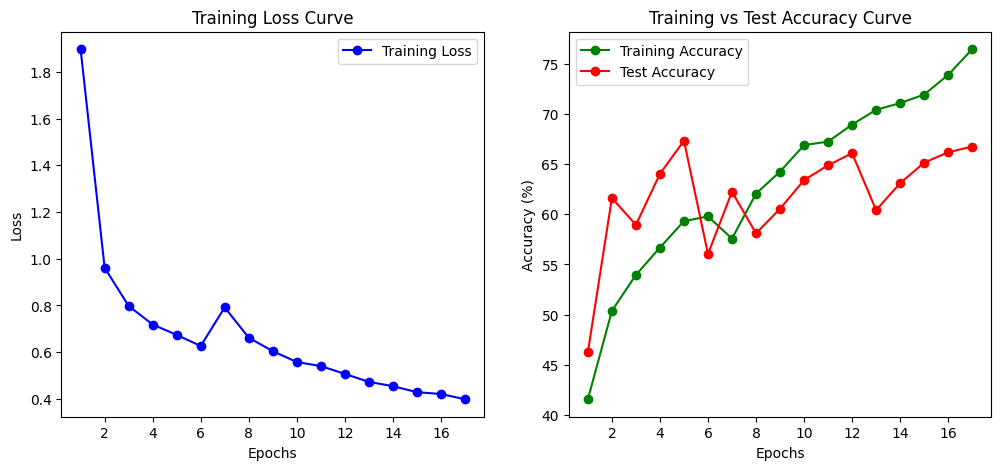

In [ ]:
# train
train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, epochs=60, patience=12)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (3D CNN)')
    plt.show()

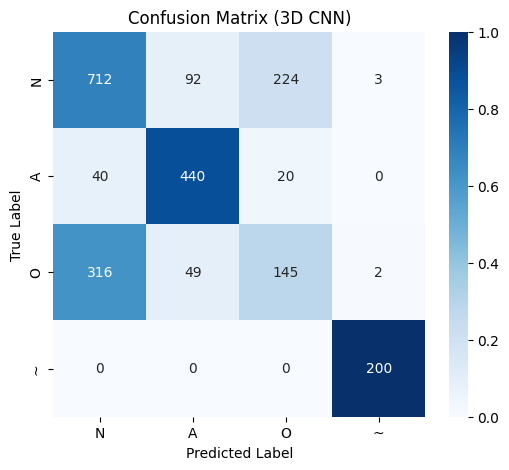

In [ ]:
acc, f1_macro, f1_weighted, all_targets, all_preds = evaluate_model(model, test_loader, log_results=False)

target_names = ['N', 'A', 'O', '~']
plot_confusion_matrix(all_targets, all_preds, target_names)

In [ ]:
# Compute per-class F1 scores
f1_scores = f1_score(all_targets, all_preds, average=None)

# Print F1 scores per class with names
print("F1 Scores per class:")
for cls, score in zip(target_names, f1_scores):
    print(f"  Class {cls}: {score:.4f}")

F1 Scores per class:
  Class N: 0.6784
  Class A: 0.8141
  Class O: 0.3219
  Class ~: 0.9877


# ENSEMBLE

# 3 different models for ECG time serie, FFT and Derivative & combine them in ensemble

In [ ]:
# Helper Functions

def pad_or_truncate(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    return signal

def apply_fft(signal):
    fft_values = np.abs(np.fft.fft(signal))[:len(signal)//2]  # Take only positive frequencies
    return fft_values

def compute_derivative(signal):
    return np.diff(signal, prepend=signal[0])  # keep same length

def standardize_signal_column(signals):
    scaler = StandardScaler()
    return scaler.fit_transform(signals)

# Load and Prepare Data

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/Healthcare/full_ecg_with_answers.csv')

# Drop metadata columns
metadata_cols = ['File_ID', 'Num_Leads', 'Sampling_Rate', 'Num_Samples', 'Gain', 'Offset', 'Signal_Type']
df = df.drop(columns=metadata_cols)

# Convert string to array
df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: np.array(eval(x)))

# Pad/truncate to 18000
df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: pad_or_truncate(x, 18000))

# Add FFT
df['ECG_FFT'] = df['ECG_Signal'].apply(apply_fft)
df['ECG_FFT'] = df['ECG_FFT'].apply(lambda x: pad_or_truncate(x, 18000))

# Add Derivative
df['ECG_Deriv'] = df['ECG_Signal'].apply(compute_derivative)
df['ECG_Deriv'] = df['ECG_Deriv'].apply(lambda x: pad_or_truncate(x, 18000))

# Convert label to numeric
label_mapping = {'N': 0, 'A': 1, 'O': 2, '~': 3}
df['Label_numeric'] = df['Label'].map(label_mapping)


In [ ]:
# --- Extract individual channels ---
X_raw    = np.stack(df['ECG_Signal'].values)
X_fft    = np.stack(df['ECG_FFT'].values)
X_deriv  = np.stack(df['ECG_Deriv'].values)
y_original = df['Label_numeric'].values

# --- SMOTE on Raw Signal Only ---
X_raw_flat = X_raw.reshape(X_raw.shape[0], -1)

smote = SMOTE(sampling_strategy={1: 2500, 3: 1000}, random_state=42)
X_raw_flat_resampled, y_resampled = smote.fit_resample(X_raw_flat, y_original)

# --- Reshape raw signal back ---
X_raw_resampled = X_raw_flat_resampled.reshape(-1, 18000)

# --- Match other modalities using same indices ---
# IMPORTANT: Use the resampling indices from SMOTE
# We recover the indices used by SMOTE by matching the flattened array
from sklearn.neighbors import NearestNeighbors

def match_resampled_indices(X_original_flat, X_resampled_flat):
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original_flat)
    distances, indices = nbrs.kneighbors(X_resampled_flat)
    return indices.flatten()

indices_resampled = match_resampled_indices(X_raw_flat, X_raw_flat_resampled)
X_fft_resampled   = X_fft[indices_resampled]
X_deriv_resampled = X_deriv[indices_resampled]

# --- Standardize Each Signal Type Separately ---
X_raw_std   = standardize_signal_column(X_raw_resampled)
X_fft_std   = standardize_signal_column(X_fft_resampled)
X_deriv_std = standardize_signal_column(X_deriv_resampled)



In [ ]:
class DeepECG_CNN(nn.Module):
    def __init__(self, input_length=18000, num_classes=4):
        super(DeepECG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.pool5 = nn.AdaptiveAvgPool1d(1)  # compress to (batch, 256, 1)

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
# Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw_std, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_raw[:, np.newaxis, :], dtype=torch.float32)  # shape: [B, 1, 18000]
X_test_tensor = torch.tensor(X_test_raw[:, np.newaxis, :], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optional sanity check
print("Input shape:", X_train_tensor.shape)
print("Train batch example:", next(iter(train_loader))[0].shape)


Input shape: torch.Size([8968, 1, 18000])
Train batch example: torch.Size([128, 1, 18000])


In [ ]:
import copy

def train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, epochs=60, patience=8,save_path=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.3, patience=2, verbose=True, min_lr=1e-6
    )

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0
    patience_counter = 0

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        test_acc = accuracy_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds, average='macro')
        test_accuracies.append(test_acc)

        scheduler.step(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2%}, Test Accuracy: {test_acc:.2%}, Macro F1: {test_f1:.4f}")

        # Early stopping
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_model_wts = copy.deepcopy(model.state_dict())

            # 🔽 Save best weights if path is provided
            if save_path is not None:
                torch.save(best_model_wts, save_path)

            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best weights from memory or disk
    if save_path is not None and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    else:
        model.load_state_dict(best_model_wts)

    return model

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model_raw = DeepECG_CNN(input_length=18000, num_classes=4).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_raw.parameters(), lr=5e-4, weight_decay=1e-5)

# Train model
model_raw = train_model_with_early_stopping(
    model_raw, train_loader, test_loader, criterion, optimizer,
    epochs=60, patience=8, save_path='best_weights_raw.pth'
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60], Loss: 1.1516, Accuracy: 49.31%, Test Accuracy: 53.86%, Macro F1: 0.4099
Epoch [2/60], Loss: 1.0059, Accuracy: 58.16%, Test Accuracy: 60.05%, Macro F1: 0.5156
Epoch [3/60], Loss: 0.9541, Accuracy: 59.75%, Test Accuracy: 62.42%, Macro F1: 0.5507
Epoch [4/60], Loss: 0.8979, Accuracy: 62.37%, Test Accuracy: 57.11%, Macro F1: 0.4644
Epoch [5/60], Loss: 0.8772, Accuracy: 62.92%, Test Accuracy: 64.07%, Macro F1: 0.5789
Epoch [6/60], Loss: 0.8462, Accuracy: 64.91%, Test Accuracy: 57.65%, Macro F1: 0.4713
Epoch [7/60], Loss: 0.8211, Accuracy: 65.81%, Test Accuracy: 65.85%, Macro F1: 0.5993
Epoch [8/60], Loss: 0.8135, Accuracy: 66.11%, Test Accuracy: 65.76%, Macro F1: 0.5807
Epoch [9/60], Loss: 0.7823, Accuracy: 67.90%, Test Accuracy: 64.11%, Macro F1: 0.5886
Epoch [10/60], Loss: 0.7739, Accuracy: 67.63%, Test Accuracy: 67.90%, Macro F1: 0.6399
Epoch [11/60], Loss: 0.7451, Accuracy: 69.34%, Test Accuracy: 52.34%, Macro F1: 0.5364
Epoch [12/60], Loss: 0.7407, Accuracy: 69.28%, Test 

In [ ]:
# Set model to eval mode
model_raw.eval()

# Move test data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Get predictions
with torch.no_grad():
    outputs = model_raw(X_test_tensor)
    y_pred = torch.argmax(F.softmax(outputs, dim=1), dim=1)

# Move to CPU for sklearn
y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Evaluate overall accuracy and macro F1
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Macro F1 Score: {f1_macro:.4f}")

# Per-class F1 scores
target_names = ['N', 'A', 'O', '~']  # adjust if needed
f1_scores = f1_score(y_true, y_pred, average=None)

print("F1 Scores per class:")
for cls, score in zip(target_names, f1_scores):
    print(f"  Class {cls}: {score:.4f}")


✅ Accuracy: 75.12%
✅ Macro F1 Score: 0.7439
F1 Scores per class:
  Class N: 0.8053
  Class A: 0.8263
  Class O: 0.4099
  Class ~: 0.9340


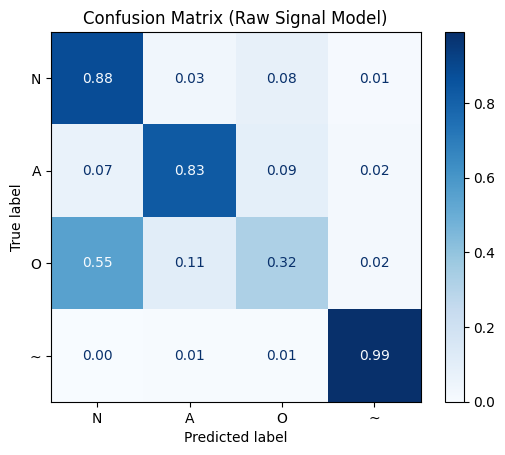

In [ ]:
# Define your class labels
class_labels = ['N', 'A', 'O', '~']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='.2f')
plt.title("Confusion Matrix (Raw Signal Model)")
plt.show()


In [ ]:

class FFT_CNN(nn.Module):
    def __init__(self, input_length=18000, num_classes=4):
        super(FFT_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        # Flattened size computation
        dummy_input = torch.zeros(1, 1, input_length)
        x = self._forward_conv(dummy_input)
        self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Use same test split logic

X_train, X_test, y_train, y_test = train_test_split(
    X_fft_std, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train[:, np.newaxis, :], dtype=torch.float32)  # shape: [B, 1, 18000]
X_test_tensor = torch.tensor(X_test[:, np.newaxis, :], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# Instantiate model
fft_model = FFT_CNN(input_length=18000, num_classes=4).to(device)

# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(fft_model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.3, verbose=True)

# Train
train_model_with_early_stopping(
    model=fft_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=60,
    patience=10,
    save_path='best_weights_fft.pth'
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60], Loss: 2.4651, Accuracy: 40.47%, Test Accuracy: 47.21%, Macro F1: 0.2171
Epoch [2/60], Loss: 1.1256, Accuracy: 48.14%, Test Accuracy: 55.86%, Macro F1: 0.4793
Epoch [3/60], Loss: 1.0171, Accuracy: 54.40%, Test Accuracy: 59.96%, Macro F1: 0.5591
Epoch [4/60], Loss: 0.9467, Accuracy: 56.71%, Test Accuracy: 65.00%, Macro F1: 0.6435
Epoch [5/60], Loss: 0.8409, Accuracy: 61.89%, Test Accuracy: 68.35%, Macro F1: 0.6511
Epoch [6/60], Loss: 0.7597, Accuracy: 65.45%, Test Accuracy: 70.66%, Macro F1: 0.6803
Epoch [7/60], Loss: 0.6904, Accuracy: 68.54%, Test Accuracy: 70.93%, Macro F1: 0.7053
Epoch [8/60], Loss: 0.6367, Accuracy: 71.54%, Test Accuracy: 73.07%, Macro F1: 0.7443
Epoch [9/60], Loss: 0.5851, Accuracy: 73.07%, Test Accuracy: 72.31%, Macro F1: 0.7096
Epoch [10/60], Loss: 0.5645, Accuracy: 74.71%, Test Accuracy: 62.77%, Macro F1: 0.6961
Epoch [11/60], Loss: 0.5470, Accuracy: 75.45%, Test Accuracy: 73.70%, Macro F1: 0.7732
Epoch [12/60], Loss: 0.5185, Accuracy: 77.61%, Test 

FFT_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144000, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# Set model to eval mode
fft_model.eval()

# Move test data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Get predictions
with torch.no_grad():
    outputs = fft_model(X_test_tensor)
    y_pred = torch.argmax(F.softmax(outputs, dim=1), dim=1)

# Move to CPU for sklearn
y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Evaluate overall accuracy and macro F1
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Macro F1 Score: {f1_macro:.4f}")

# Per-class F1 scores
target_names = ['N', 'A', 'O', '~']  # adjust if needed
f1_scores = f1_score(y_true, y_pred, average=None)

print("F1 Scores per class:")
for cls, score in zip(target_names, f1_scores):
    print(f"  Class {cls}: {score:.4f}")

✅ Accuracy: 73.70%
✅ Macro F1 Score: 0.7732
F1 Scores per class:
  Class N: 0.7501
  Class A: 0.8896
  Class O: 0.4968
  Class ~: 0.9563


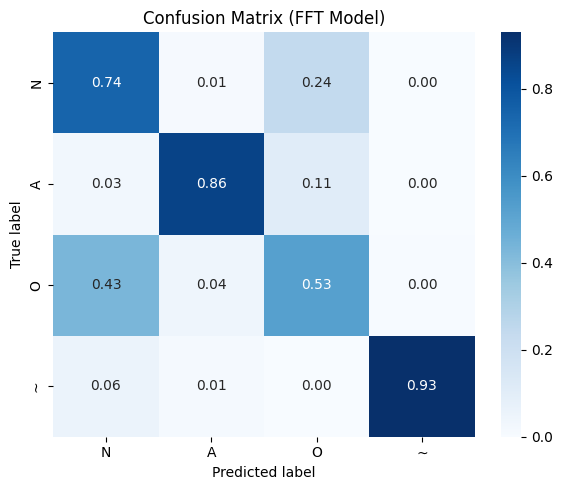

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
labels = ['N', 'A', 'O', '~']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (FFT Model)")
plt.tight_layout()
plt.show()


In [ ]:
class CNN_Deriv(nn.Module):
    def __init__(self, input_length=18000, num_classes=4):
        super(CNN_Deriv, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 48, kernel_size=3, padding=1)  # NEW
        self.bn3 = nn.BatchNorm1d(48)
        self.pool3 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.3)

        # Compute final feature size
        dummy_input = torch.zeros(1, 1, input_length)
        out = self._forward_features(dummy_input)
        final_feat_dim = out.shape[1]

        self.fc = nn.Linear(final_feat_dim, num_classes)

    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
# Derivative signal training prep
X_train, X_test, y_train, y_test = train_test_split(
    X_deriv_std, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train[:, np.newaxis, :], dtype=torch.float32)  # shape: [B, 1, 18000]
X_test_tensor = torch.tensor(X_test[:, np.newaxis, :], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Deriv(input_length=18000, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

trained_model = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=60,
    patience=10,
    save_path='best_weights_deriv.pth'
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60], Loss: 2.3890, Accuracy: 46.28%, Test Accuracy: 36.65%, Macro F1: 0.4456
Epoch [2/60], Loss: 0.9534, Accuracy: 64.24%, Test Accuracy: 52.16%, Macro F1: 0.6156
Epoch [3/60], Loss: 0.6619, Accuracy: 74.29%, Test Accuracy: 67.05%, Macro F1: 0.6115
Epoch [4/60], Loss: 0.6365, Accuracy: 76.65%, Test Accuracy: 66.12%, Macro F1: 0.6777
Epoch [5/60], Loss: 0.3866, Accuracy: 84.83%, Test Accuracy: 66.70%, Macro F1: 0.6650
Epoch [6/60], Loss: 0.3688, Accuracy: 86.11%, Test Accuracy: 68.93%, Macro F1: 0.6667
Epoch [7/60], Loss: 0.2623, Accuracy: 89.76%, Test Accuracy: 65.89%, Macro F1: 0.6758
Epoch [8/60], Loss: 0.2111, Accuracy: 92.62%, Test Accuracy: 67.14%, Macro F1: 0.6902
Epoch [9/60], Loss: 0.1766, Accuracy: 93.81%, Test Accuracy: 62.51%, Macro F1: 0.6552
Epoch [10/60], Loss: 0.1187, Accuracy: 96.13%, Test Accuracy: 66.56%, Macro F1: 0.7020
Epoch [11/60], Loss: 0.0893, Accuracy: 96.83%, Test Accuracy: 64.69%, Macro F1: 0.6998
Epoch [12/60], Loss: 0.0849, Accuracy: 97.23%, Test 

In [ ]:
# Set model to eval mode
model.eval()

# Move test data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(F.softmax(outputs, dim=1), dim=1)

# Move to CPU for sklearn
y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Evaluate overall accuracy and macro F1
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Macro F1 Score: {f1_macro:.4f}")

# Per-class F1 scores
target_names = ['N', 'A', 'O', '~']  # adjust if needed
f1_scores = f1_score(y_true, y_pred, average=None)

print("F1 Scores per class:")
for cls, score in zip(target_names, f1_scores):
    print(f"  Class {cls}: {score:.4f}")

✅ Accuracy: 66.56%
✅ Macro F1 Score: 0.7020
F1 Scores per class:
  Class N: 0.6747
  Class A: 0.8583
  Class O: 0.2975
  Class ~: 0.9776


<Figure size 600x600 with 0 Axes>

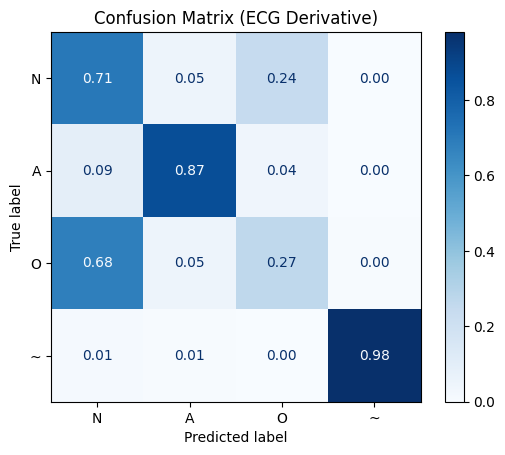

In [ ]:
# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'A', 'O', '~'])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format=".2f", colorbar=True)
plt.title("Confusion Matrix (ECG Derivative)")
plt.grid(False)
plt.show()


In [ ]:
# Re-initialize the models with correct architecture
raw_model = DeepECG_CNN(input_length=18000, num_classes=4).to(device)
fft_model = FFT_CNN(input_length=18000, num_classes=4).to(device)
deriv_model = CNN_Deriv(input_length=18000, num_classes=4).to(device)

# Load saved weights
raw_model.load_state_dict(torch.load('best_weights_raw.pth'))
fft_model.load_state_dict(torch.load('best_weights_fft.pth'))
deriv_model.load_state_dict(torch.load('best_weights_deriv.pth'))

# Set models to eval
raw_model.eval()
fft_model.eval()
deriv_model.eval()


CNN_Deriv(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 48, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=108000, out_features=4, bias=True)
)

In [ ]:
def prepare_input_tensor(X):
    """
    Ensure tensor shape is [B, 1, L] for Conv1D models.
    Accepts numpy arrays or PyTorch tensors.
    """
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)

    if X.ndim == 2:
        # From [B, L] → [B, 1, L]
        X = X.unsqueeze(1)
    return X


In [ ]:
X_test_tensor_raw   = prepare_input_tensor(X_test_raw).to(device).float()
X_test_tensor_fft   = prepare_input_tensor(X_test_fft).to(device).float()
X_test_tensor_deriv = prepare_input_tensor(X_test_deriv).to(device).float()

# Optional: verify shapes
print("RAW   shape:", X_test_tensor_raw.shape)
print("FFT   shape:", X_test_tensor_fft.shape)
print("DERIV shape:", X_test_tensor_deriv.shape)


RAW   shape: torch.Size([2243, 1, 18000])
FFT   shape: torch.Size([2243, 1, 18000])
DERIV shape: torch.Size([2243, 1, 18000])


In [ ]:
def get_model_predictions(model, input_tensor, batch_size=128):
    model.eval()
    probs = []

    with torch.no_grad():
        for i in range(0, input_tensor.size(0), batch_size):
            batch = input_tensor[i:i+batch_size]
            output = model(batch)
            prob = F.softmax(output, dim=1)
            probs.append(prob.cpu())

    return torch.cat(probs, dim=0).numpy()


In [ ]:
probs_fft   = get_model_predictions(fft_model, X_test_tensor_fft)
probs_deriv = get_model_predictions(deriv_model, X_test_tensor_deriv)
probs_raw   = get_model_predictions(raw_model, X_test_tensor_raw)


In [ ]:

# 1. Prepare tensors for inference
X_test_tensor_raw   = prepare_input_tensor(X_test_raw).to(device).float()
X_test_tensor_fft   = prepare_input_tensor(X_test_fft).to(device).float()
X_test_tensor_deriv = prepare_input_tensor(X_test_deriv).to(device).float()

# 2. Get probabilities from each model
probs_raw   = get_model_predictions(raw_model, X_test_tensor_raw)
probs_fft   = get_model_predictions(fft_model, X_test_tensor_fft)
probs_deriv = get_model_predictions(deriv_model, X_test_tensor_deriv)

# 3. Average predictions (simple or weighted)
# Simple average
#probs_ensemble = (probs_raw + probs_fft + probs_deriv) / 3.0

# Optional: weighted average
probs_ensemble = 0.4 * probs_raw + 0.4 * probs_fft + 0.2 * probs_deriv

# 4. Final predictions
y_pred_ensemble = np.argmax(probs_ensemble, axis=1)

# 5. Evaluate
acc = accuracy_score(y_test_raw, y_pred_ensemble)
f1_macro = f1_score(y_test_raw, y_pred_ensemble, average='macro')
f1_per_class = f1_score(y_test_raw, y_pred_ensemble, average=None)

# 6. Print
print(f"✅ Ensemble Accuracy: {acc*100:.2f}%")
print(f"✅ Ensemble Macro F1: {f1_macro:.4f}")
print("F1 Scores per class:")
for cls, score in zip(target_names, f1_per_class):
    print(f"  - Class {cls}: {score:.4f}")


✅ Ensemble Accuracy: 77.71%
✅ Ensemble Macro F1: 0.7881
F1 Scores per class:
  - Class N: 0.8027
  - Class A: 0.9253
  - Class O: 0.4444
  - Class ~: 0.9802
